In [1]:
# Install dependencies
!pip install -q tensorflow
!pip install -q matplotlib
!pip install -q seaborn


In [2]:
# Import libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


In [3]:
from google.colab import files
files.upload()  # Upload kaggle.json


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ashritha03102004","key":"5d456b0ed5dce5994cb35603c1fb9280"}'}

In [4]:
!kaggle datasets download -d <dataset-id>
!unzip -q <downloaded-file.zip> -d garbage_dataset


/bin/bash: -c: line 1: syntax error near unexpected token `newline'
/bin/bash: -c: line 1: `kaggle datasets download -d <dataset-id>'
/bin/bash: line 1: downloaded-file.zip: No such file or directory


In [7]:
import zipfile

with zipfile.ZipFile("E-Waste classification dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("garbage_dataset")


In [8]:
import os
os.listdir("garbage_dataset")


['modified-dataset']

In [10]:
os.listdir("garbage_dataset/modified-dataset")
os.listdir("garbage_dataset/modified-dataset/test")


['Washing Machine',
 'Microwave',
 'Mouse',
 'Mobile',
 'Printer',
 'Player',
 'PCB',
 'Keyboard',
 'Battery',
 'Television']

In [11]:
import os, shutil
from sklearn.model_selection import train_test_split

source_dir = "garbage_dataset/modified-dataset/test"
train_dir = "garbage_dataset/train"
val_dir = "garbage_dataset/val"

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

for class_name in os.listdir(source_dir):
    class_path = os.path.join(source_dir, class_name)
    if os.path.isdir(class_path):
        images = os.listdir(class_path)
        train_imgs, val_imgs = train_test_split(images, test_size=0.2, random_state=42)

        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)

        for img in train_imgs:
            shutil.copy(os.path.join(class_path, img), os.path.join(train_dir, class_name, img))
        for img in val_imgs:
            shutil.copy(os.path.join(class_path, img), os.path.join(val_dir, class_name, img))


In [46]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_height, img_width = 224, 224
batch_size = 32
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    "garbage_dataset/train",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

val_data = val_datagen.flow_from_directory(
    "garbage_dataset/val",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)


Found 240 images belonging to 10 classes.
Found 60 images belonging to 10 classes.


In [13]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam


In [14]:
# Load EfficientNetV2B0 base model (without top)
base_model = EfficientNetV2B0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model for now


24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [15]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
output = Dense(train_data.num_classes, activation='softmax')(x)  # Number of classes from data

model = Model(inputs=base_model.input, outputs=output)


In [16]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [17]:
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          0 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ normalization[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 112, 112,  │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 112, 112,  │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 56, 56,    │      9,216 │ block1a_project_… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 56, 56,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 56, 56,    │          0 │ block2a_expand_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_co… │ (None, 56, 56,    │      2,048 │ block2a_expand_a… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_bn  │ (None, 56, 56,    │        128 │ block2a_project_… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_conv │ (None, 56, 56,    │     36,864 │ block2a_project_… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_bn   │ (None, 56, 56,    │        512 │ block2b_expand_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_act… │ (None, 56, 56,    │          0 │ block2b_expand_b

 Total params: 5,932,122 (22.63 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

In [18]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [31]:
# Save the best model
checkpoint = ModelCheckpoint("best_model.keras", monitor="val_accuracy", save_best_only=True, mode="max", verbose=1)

# Stop if no improvement for 5 epochs
early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)


In [32]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    callbacks=[checkpoint, early_stop]
)


Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0983 - loss: 2.3299
Epoch 1: val_accuracy improved from -inf to 0.18333, saving model to best_model.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.0976 - loss: 2.3303 - val_accuracy: 0.1833 - val_loss: 2.2995
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1201 - loss: 2.2943
Epoch 2: val_accuracy did not improve from 0.18333
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.1188 - loss: 2.2975 - val_accuracy: 0.1833 - val_loss: 2.2993
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0931 - loss: 2.3223
Epoch 3: val_accuracy did not improve from 0.18333
8/8 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.0930 - loss: 2.3216 - val_accuracy: 0.1333 - val_loss: 2.2991
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1067 - loss: 2.3150
Epoch 4: val_accuracy did not improve from 0.18333
8/8 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.1087 - loss: 2.3119 - val_accuracy: 0.1333 - va

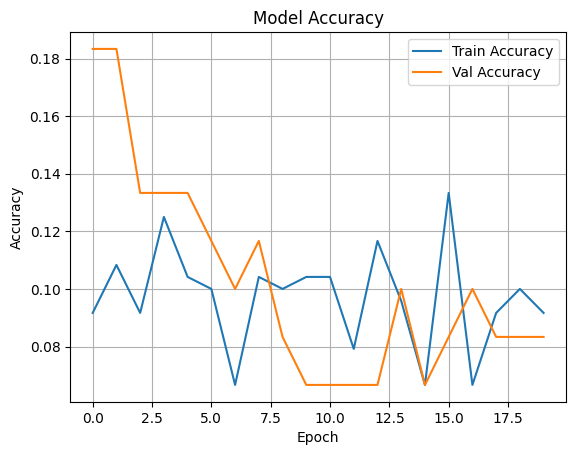

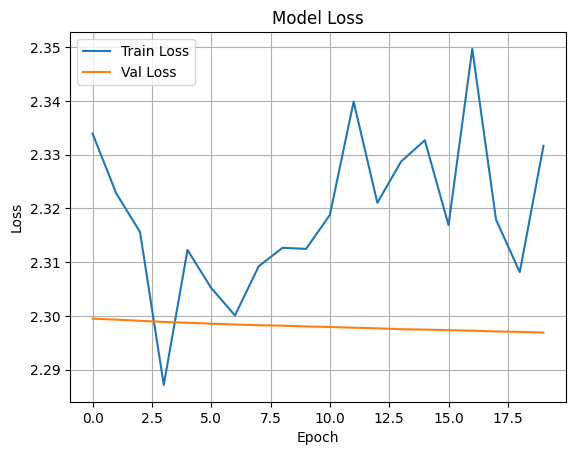

In [33]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


In [56]:
base_model.trainable = True
for layer in base_model.layers[:-5]:  # Train almost all layers
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_data, validation_data=val_data, epochs=20, callbacks=[checkpoint, early_stop])


Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0947 - loss: 2.3058
Epoch 1: val_accuracy did not improve from 0.18333
8/8 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - accuracy: 0.0962 - loss: 2.3043 - val_accuracy: 0.1167 - val_loss: 2.2957
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1296 - loss: 2.3198
Epoch 2: val_accuracy did not improve from 0.18333
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.1249 - loss: 2.3212 - val_accuracy: 0.1167 - val_loss: 2.2957
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1303 - loss: 2.3166
Epoch 3: val_accuracy did not improve from 0.18333
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.1297 - loss: 2.3160 - val_accuracy: 0.1333 - val_loss: 2.2957
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0841 - loss: 2.3175
Epoch 4: val_accuracy did not improve from 0.18333
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.0836 - loss: 2.3182 - val_accuracy: 0.1167 - val_loss: 2.2957
Epoch 5/20
8/8 ━━━━━

In [57]:
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])


In [58]:
history = model.fit(train_data, validation_data=val_data, epochs=10, callbacks=[checkpoint, early_stop])


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1344 - loss: 2.3301
Epoch 1: val_accuracy did not improve from 0.18333
8/8 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - accuracy: 0.1329 - loss: 2.3298 - val_accuracy: 0.1667 - val_loss: 2.2955
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1282 - loss: 2.3087
Epoch 2: val_accuracy did not improve from 0.18333
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.1251 - loss: 2.3087 - val_accuracy: 0.1333 - val_loss: 2.2954
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0983 - loss: 2.3342
Epoch 3: val_accuracy did not improve from 0.18333
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.1008 - loss: 2.3316 - val_accuracy: 0.1167 - val_loss: 2.2954
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1146 - loss: 2.2967
Epoch 4: val_accuracy did not improve from 0.18333
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.1148 - loss: 2.2961 - val_accuracy: 0.1167 - val_loss: 2.2954
Epoch 5/10
8/8 ━━━━━

In [59]:
val_loss, val_acc = model.evaluate(val_data)
print(f"Validation Accuracy: {val_acc:.2f}")
print(f"Validation Loss: {val_loss:.2f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.1083 - loss: 2.2962
Validation Accuracy: 0.10
Validation Loss: 2.30


In [40]:
from google.colab import files
uploaded = files.upload()


Saving battery_174.jpg to battery_174.jpg


In [60]:
from tensorflow.keras.preprocessing import image
import numpy as np

# ✅ Use the actual file name you uploaded
img_path = "battery_174.jpg"

img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Predict
pred = model.predict(img_array)
class_idx = np.argmax(pred)
class_name = list(train_data.class_indices.keys())[class_idx]

print(f"Predicted Class: {class_name}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted Class: Microwave


In [65]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [66]:
from tensorflow.keras.applications import EfficientNetV2B2
base_model = EfficientNetV2B2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')


35839040/35839040 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [61]:
!pip install -q gradio


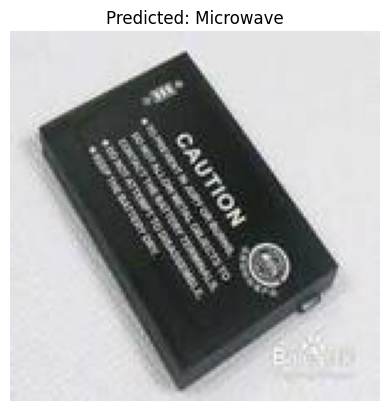

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://fae9ef1e70ba289d7c.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [62]:
import matplotlib.pyplot as plt

plt.imshow(image.load_img(img_path))
plt.axis('off')
plt.title(f"Predicted: {class_name}")
plt.show()
import gradio as gr

# Define class labels (in correct order)
class_names = list(train_data.class_indices.keys())

def predict_image(img):
    img = img.resize((224, 224))
    img = np.array(img) / 255.0
    img = np.expand_dims(img, axis=0)
    pred = model.predict(img)[0]
    return {class_names[i]: float(pred[i]) for i in range(len(class_names))}

# Build Gradio interface
interface = gr.Interface(
    fn=predict_image,
    inputs=gr.Image(type="pil"),
    outputs=gr.Label(num_top_classes=3),
    title="E-Waste Image Classifier",
    description="Upload an image of electronic waste to classify it (e.g., mobile, charger, laptop...)."
)

interface.launch()


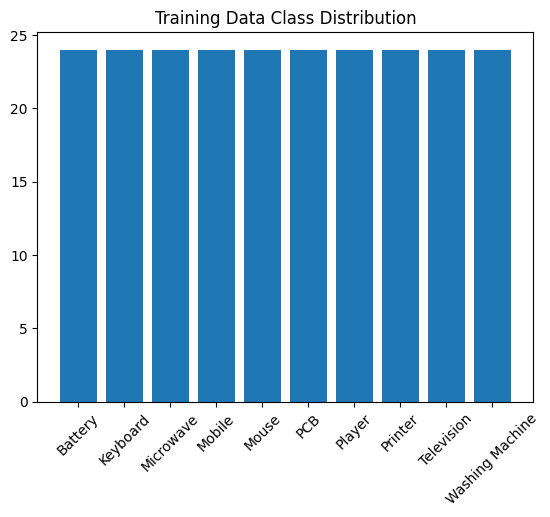

In [64]:
from collections import Counter
import matplotlib.pyplot as plt

labels = train_data.classes
label_names = list(train_data.class_indices.keys())

class_counts = Counter(labels)
plt.bar(label_names, [class_counts[i] for i in range(len(label_names))])
plt.xticks(rotation=45)
plt.title("Training Data Class Distribution")
plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 5s/step


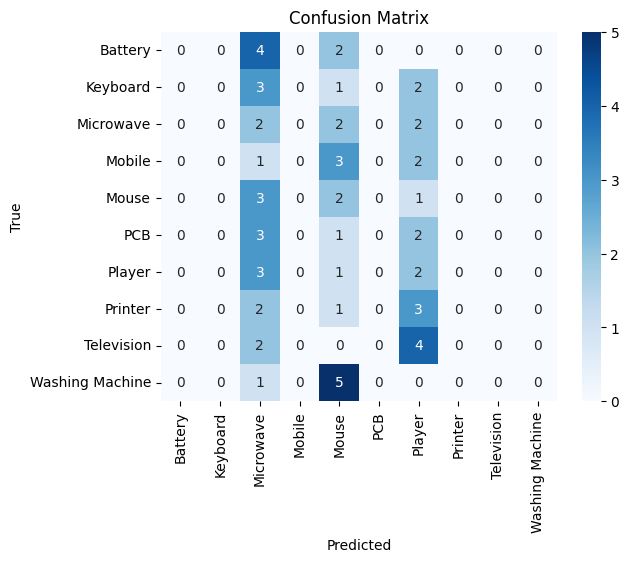

In [63]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Get predictions
Y_pred = model.predict(val_data)
y_pred = np.argmax(Y_pred, axis=1)

# True labels
true_classes = val_data.classes
class_labels = list(val_data.class_indices.keys())

# Confusion matrix
cm = confusion_matrix(true_classes, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
